In [1]:
%matplotlib inline
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import scipy.signal as signal
from scipy.fftpack import fft
import numpy as np
import re
import random

In [2]:
def load_data(filename, time_column, time_unit):
    """
    Load data from file, estimate the a 'relevant' sample rate
    :param filename: name of input data file
    :param time_column: column in which timeticks are stored
    :param time_unit: time unit
    :return: a dataframe and the computed sample rate
    """
    # load data in a pandas DataFrame
    df = pd.read_csv(filename)
    # estimate the sample rate
    sample_rate = int(round(df.loc[len(df)-1][time_column]/len(df)))
    # convert time column as datetime
    df[time_column] = df[time_column].astype('datetime64['+time_unit+']')
    return df, sample_rate

def interpolate_waves(df, time_column, sample_rate="8L"):
    """
    Time interpolatation of waves regarding best estimated sample_rate
    :param df: Data in a dataframe
    :param time_column: column in which timeticks are stored
    :param sample_rate: best estimated sample rate as string
    :return: dictionary with a time serie per cue
    """
    result = {}
    for i, metric in enumerate([c for c in df.columns if c != time_column]):
        serie = pd.Series(index=df[time_column], data=df[metric].values)
        serie = serie.resample(sample_rate).mean()
        serie = serie.interpolate(method='time')
        result[metric] = serie
    return result

def plot_waves(waves, w_columns, create_fig=True):
    """
    Plot a set of waves
    :param waves: waves dictionary
    :param w_columns: list of key names related with cues to plot
    :param create_fig: yes/no (boolean)
    :return:
    """
    colors = ['#40bf80', '#668cff', '#ffa64d', '#ff33bb', '#330033', '#145214', '#805500', '#999900']
    if create_fig:
        plt.figure(figsize=(15, 8))
    for metric in w_columns:
        serie = waves[metric]
        serie.plot(label=metric, color=random.choice(colors), linewidth=2.0)
        plt.legend()
        
def remove_outliers(arr):
    """
    Set to 0 outliers (more than 20 std distance from the mean)
    :param arr: numpy array of float values
    """
    mean = np.mean(np.abs(arr))
    std = np.std(np.abs(arr))
    arr[np.where(np.abs(arr) > mean + 20 * std)] = 0.
    arr[np.where(np.abs(arr) < mean - 20 * std)] = 0.
        
def plot_fft(waves, w_columns, sample_rate, create_fig=True):
    """
    Plot a set of waves
    :param waves: waves dictionary
    :param w_columns: list of key names related with cues to plot
    :param create_fig: yes/no (boolean)
    :return:
    """
    colors = ['#40bf80', '#668cff', '#ffa64d', '#ff33bb', '#330033', '#145214', '#805500', '#999900']
    if create_fig:
        plt.figure(figsize=(15, 8))
    for metric in w_columns:
        serie = waves[metric]
        nb_pts = len(serie)
        yf = fft(serie.values)
        title = ''+str(yf[0:1])
        remove_outliers(yf)
        xf = np.linspace(0.0, 1.0/(2.0*sample_rate), nb_pts/2)
        plt.plot(xf, np.abs(yf[0:nb_pts/2]), label='FFT ' + metric, color=random.choice(colors))
        plt.title(title)
        plt.legend()  

In [3]:
# Get data as pandas DataFrame and sample rate
df, sample_rate = load_data('run_ankle.feet', 'timestamp', 'ms')
# Frequency sample from sample rate
fs = 1000./float(sample_rate)
print(fs)
# sample rate code for pandas interpolation
sp_r = str(sample_rate)+"L"
df.head()

125.0


,timestamp,g_x,g_y,g_z,a_x,a_y,a_z,m_x,m_y,m_z
0,1970-01-01 00:00:00.000,0.008889,-0.001111,-0.006667,-0.45,9.04,1.44,161.6,-136.2,-1.1
1,1970-01-01 00:00:00.008,0.005556,-0.003333,-0.004444,-0.50,9.03,1.42,161.6,-132.8,-1.1
2,1970-01-01 00:00:00.016,0.007778,0.000000,-0.001111,-0.48,9.02,1.49,161.6,-132.8,-1.1
3,1970-01-01 00:00:00.024,0.007778,0.000000,0.000000,-0.50,9.01,1.54,157.0,-136.2,-1.1
4,1970-01-01 00:00:00.032,0.008889,0.000000,-0.001111,-0.50,8.98,1.53,158.2,-131.6,1.1


### Store cues in a dictionnary as Time series $\Rightarrow$

In [4]:
dict_waves = interpolate_waves(df, 'timestamp', sp_r)

### Plotting cues $\Rightarrow$
All of the waves seem have a notable variability between $t_0+5s~and~t_0+18s$<br>
We can imagine that the subject has moved during this period and is quite static for the remaining time<br>
Most of then appear stationary except g_y for which stationarity is not so clear (specially at the end of variable period i.e. between $t_0+5s~and~t_0+18s$)

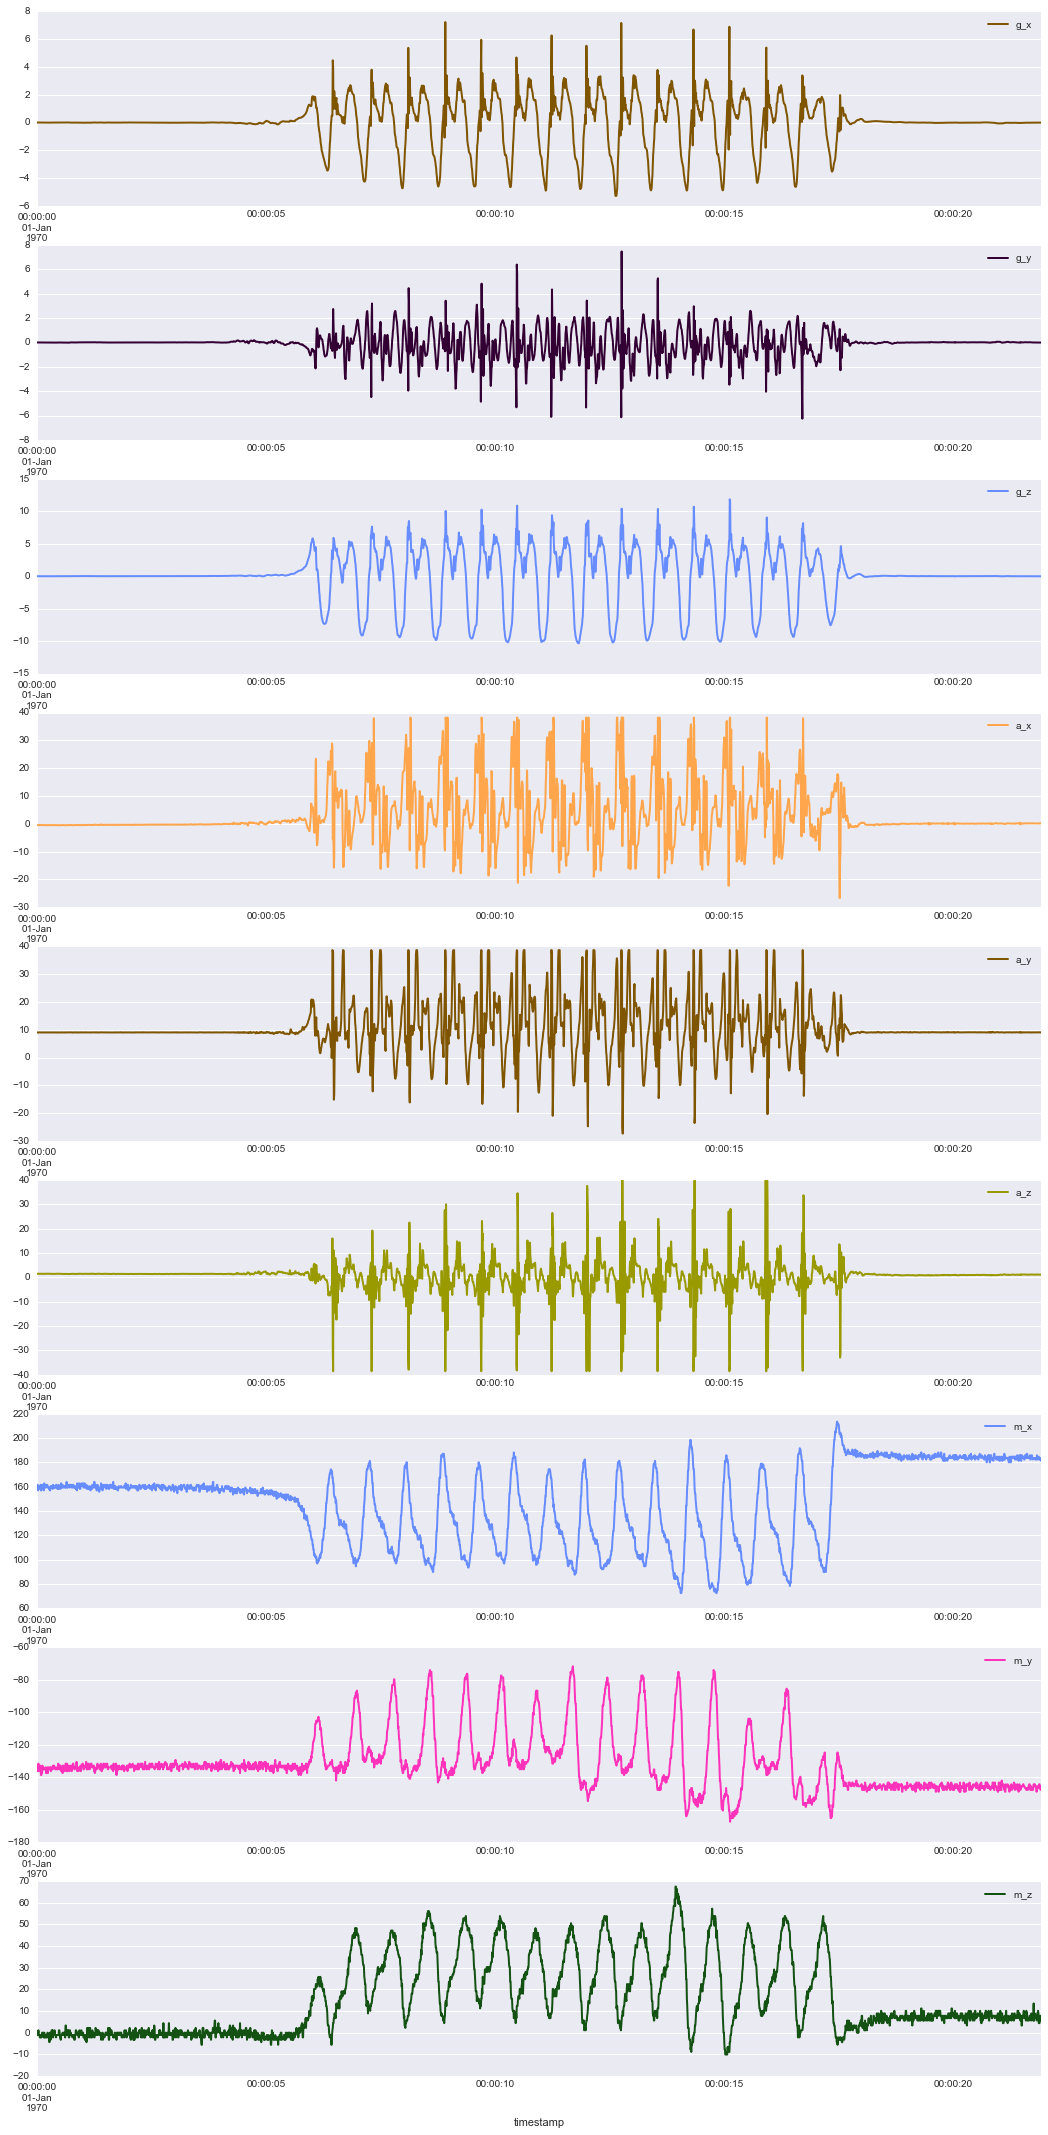

In [5]:
plt.figure(figsize=(18, 37))
for i, col in enumerate([c for c in df.columns if c != 'timestamp']):
    plt.subplot(910+i+1)
    plot_waves(dict_waves, [col], create_fig=False)

### Low pass filter function $\Rightarrow$
We have adapted code available at : https://scipy.github.io/old-wiki/pages/Cookbook/ButterworthBandpass

In [6]:
from scipy.signal import butter, lfilter

def butter_bandpass(highcut, fs, order=5):
    """
    Create a low pass filter
    """
    nyq = 0.5 * fs
    high = highcut / nyq
    b, a = butter(order, high, btype='low')
    return b, a

def butter_bandpass_filter(data, highcut, fs, order=5):
    """
    Create a low pass filter and apply it to a signal
    """
    b, a = butter_bandpass(highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

def filter_wave(waves, cue_id, highcut, fs=fs, order=5):
    """
    Create a new serie applying a low-pass filter to a wave
    """
    serie = waves[cue_id]
    return pd.Series(index=serie.index, data=butter_bandpass_filter(serie.values, highcut, fs, order))

def filter_waves(waves, highcuts, fs=fs, order=5):
    """
    Create a new wave dictionary with filtered series
    highcuts are given by wave in the highcuts parameter dictionary
    """
    result = {}
    for cue_id in waves.keys():
        serie = waves[cue_id]
        result[cue_id] = filter_wave(waves, cue_id, highcuts[cue_id])
    return result
    
def plot_filtered(waves, cue_id, highcut, fs=fs, order=5):
    colors = ['#40bf80', '#668cff', '#ffa64d', '#ff33bb', '#330033', '#145214', '#805500', '#999900']
    serie = waves[cue_id]
    serie_filtered = pd.Series(index=serie.index, data=butter_bandpass_filter(serie.values, highcut, fs, order))
    plt.figure(figsize=(18, 12))
    plt.subplot(211)
    serie.plot(label=cue_id, color=random.choice(colors), linewidth=2.0)
    plt.legend()
    plt.subplot(212)
    serie_filtered.plot(label=cue_id+"_filtered", color=random.choice(colors), linewidth=2.0)
    plt.legend()

### Spectral analysis $\Rightarrow$
We plot the FFT of each cue, removing frequencies far than mean +/- 20 std<br>
Some of the spectrum have a lot of harmonics (g_y, a_y, a_z). It is difficult to know if it is part of the measure or noise<br>

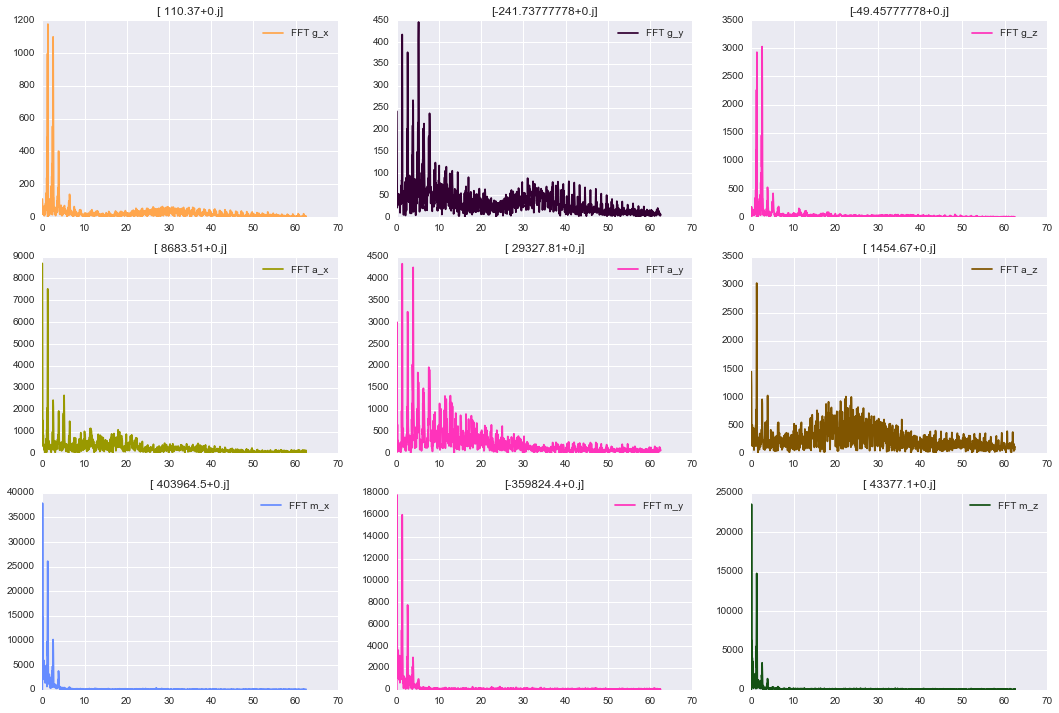

In [7]:
plt.figure(figsize=(18, 12))
for i, col in enumerate([c for c in df.columns if c != 'timestamp']):
    plt.subplot(330+i+1)
    plot_fft(dict_waves, [col], sample_rate*1e-03, create_fig=False)

In [8]:
# Choosing following cutoff by cue:
highcuts = {'g_x': 5, 'g_y': 7, 'g_z': 5, 'a_x': 5, 'a_y': 15, 'a_z': 10, 'm_x': 5, 'm_y': 5, 'm_z': 5}
dict_waves_f = filter_waves(dict_waves, highcuts, fs=fs, order=5)

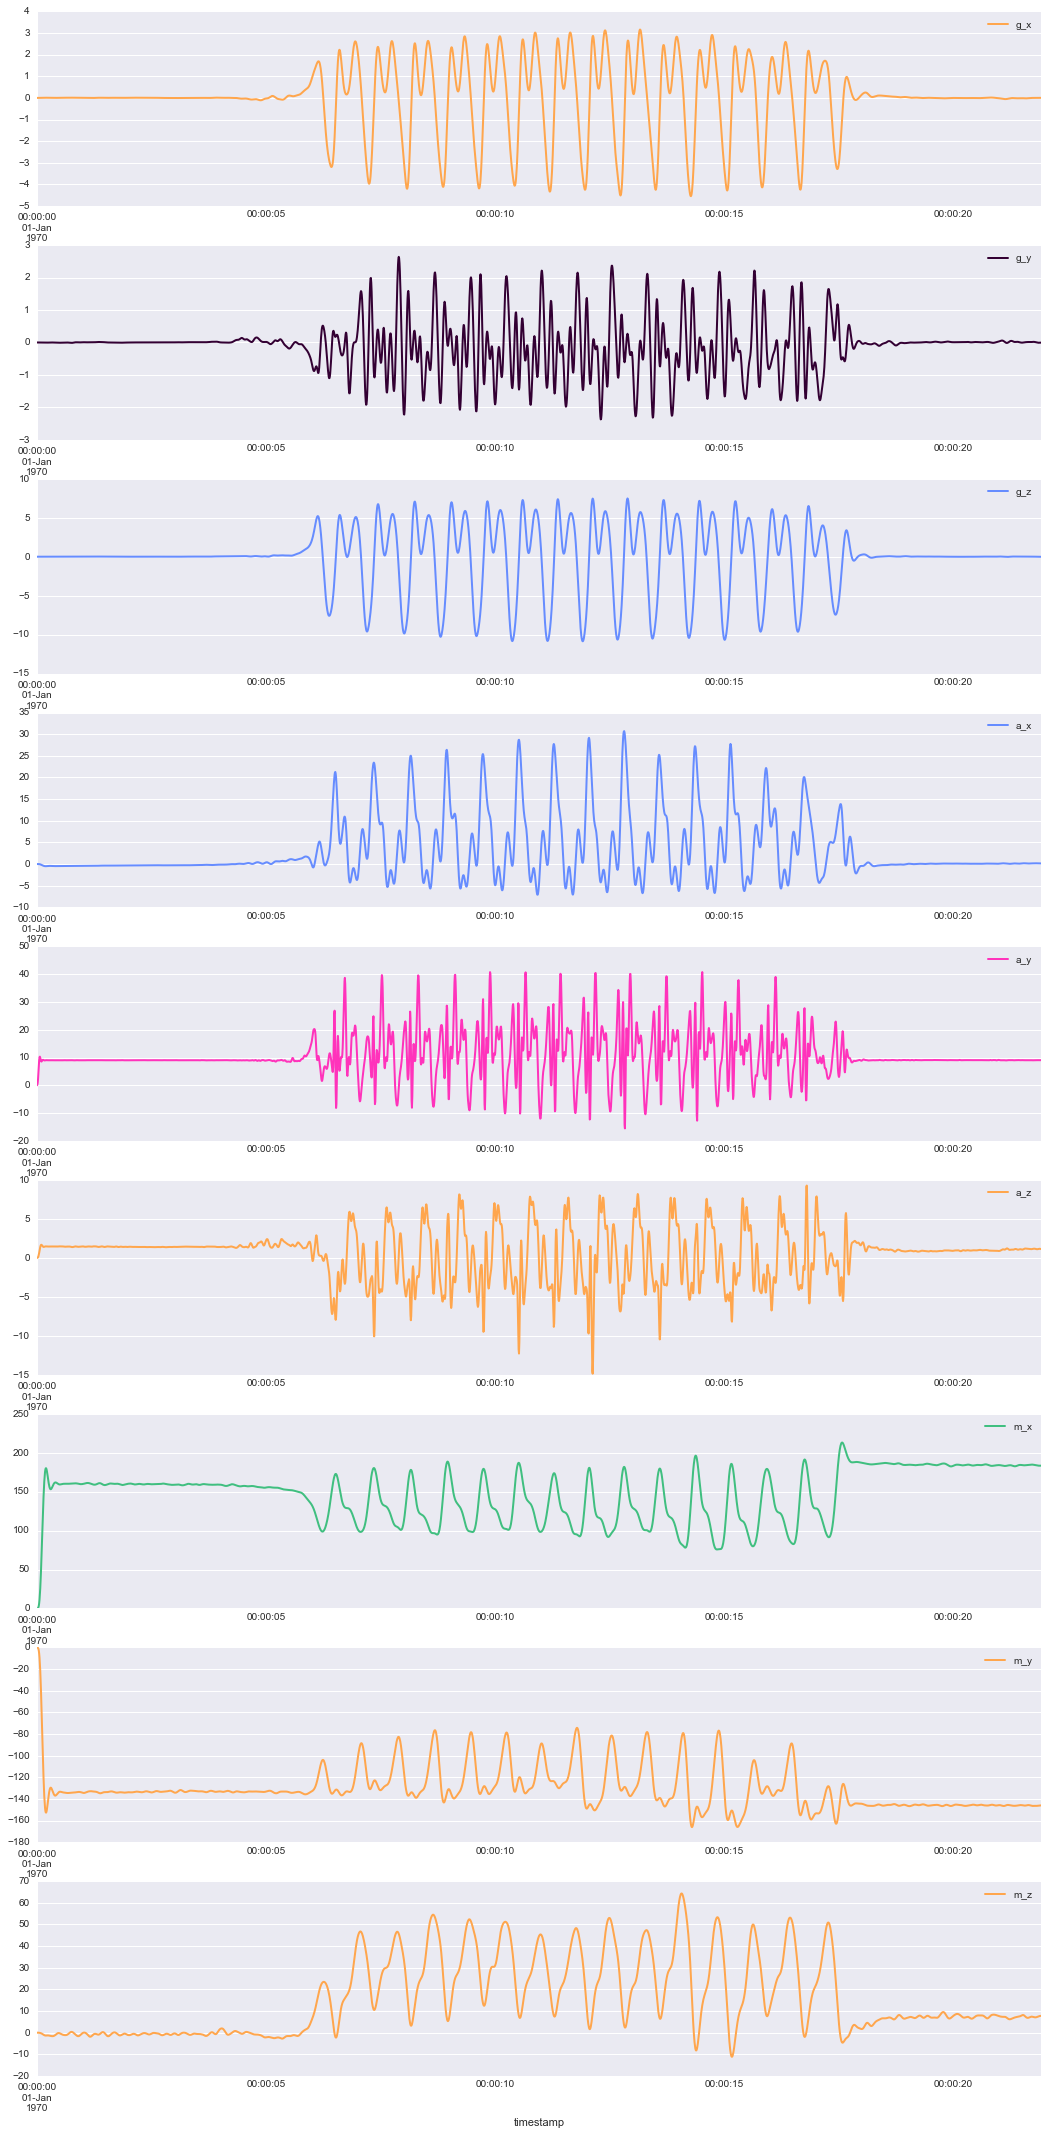

In [9]:
# plot filtered cues
plt.figure(figsize=(18, 37))
for i, col in enumerate([c for c in df.columns if c != 'timestamp']):
    plt.subplot(910+i+1)
    plot_waves(dict_waves_f, [col], create_fig=False)

### Attempt to segment steps $\Rightarrow$
We will attempt to segment steps using g_x or g_z because they are synchronized and their spectrums do not hold so much noise.<br>
On our mind, for the two waves, we have patterns similar in shape and a complete shape is related with a complete cycle of the run i.e. 2 steps (we have to take into account the second foot which has no record device)<br>
<br>
Looking at the filtered waves, we can identify a complete cycle between 2 local negative minima<br>
The positive local minima could be related to the second feet stabilization on the ground<br>
Finding the local minima could allow to segment by step.

In [10]:
from scipy.signal import argrelextrema

In [11]:
def step_segmentation(waves):
    """
    Build a serie with time ticks corresponding to step segmentation
    """
    # copy serie g_x
    serie = pd.Series(index=dict_waves_f['g_x'].index, data=dict_waves_f['g_x'].values)
    # remove points related with quasi static position (keep t0+6s to t0+18s)
    serie = serie[(serie.index>pd.to_datetime(6e9)) & (serie.index<pd.to_datetime(18e9))]
    # indices of local minima
    min_indices = argrelextrema(serie.values, np.less)
    index_min = serie.index[min_indices]
    # build a time serie with local minima only
    serie_min = pd.Series(index=index_min, data=dict_waves_f['g_x'][index_min])
    return serie, serie_min

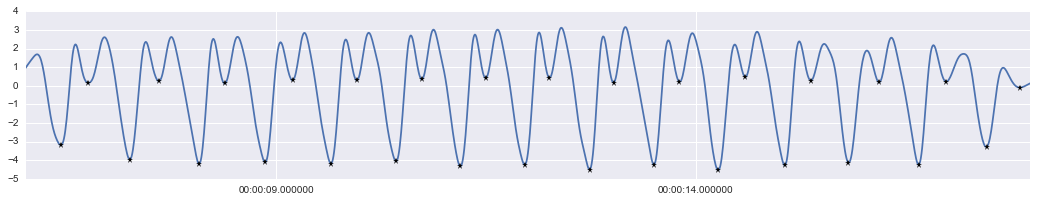

In [12]:
serie, serie_min = step_segmentation(dict_waves_f)
plt.figure(figsize=(18,3))
plt.plot(serie.index,serie.values)
plt.plot(serie_min.index,serie_min.values, '*', color='black');

### Idea to measure step duration "on line" $\Rightarrow$
If we can collect some reference shapes of cues corresponding to a running step, we can analyse the signal with a sliding window and compare it with our referential with the DWT (Dynamic Time Warping) similarity method.